In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import electric_rates as er
from vehicles import vehicle_ev, vehicle_ice, gas_costs_per_month, electr_cost_per_month

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
gas_costs = np.linspace(2.00, 4.00, 10)

erates = er.elect_rates()
erates.add_sdge_tou_ev_rates()
miles_per_month = 15000.0/12.0

## Cars
volt = vehicle_ev("Volt 2016", 0.37)
grand_vitara = vehicle_ice("grand vitara", 19, 23, average_override=21)
mazda_3 = vehicle_ice("Mazda 3 2.5l", 28, 39 )
sienna = vehicle_ice("Sienna", 19,25)
gti = vehicle_ice( "GTI", 25,33 )

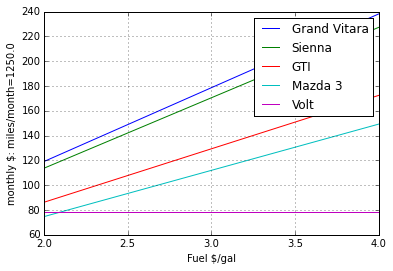

In [3]:
gv_costs_monthly = gas_costs_per_month( miles_per_month, gas_costs, grand_vitara.get_ave_mpg() )
mazda_costs_monthly = gas_costs_per_month( miles_per_month, gas_costs, mazda_3.get_ave_mpg() )
sienna_costs_monthly = gas_costs_per_month( miles_per_month, gas_costs, sienna.get_ave_mpg() )
gti_costs_monthly = gas_costs_per_month( miles_per_month, gas_costs, gti.get_ave_mpg() )
volt_costs_monthly = electr_cost_per_month( miles_per_month, erates.get_ave_rate(), volt.kwh_per_mile )
plt.plot(gas_costs, gv_costs_monthly, label="Grand Vitara")
plt.plot(gas_costs, sienna_costs_monthly, label="Sienna")
plt.plot(gas_costs, gti_costs_monthly, label="GTI")
plt.plot(gas_costs, mazda_costs_monthly, label="Mazda 3")
plt.plot(gas_costs, [volt_costs_monthly]*gas_costs.shape[0], label="Volt" )
plt.xlabel("Fuel $/gal")
plt.ylabel("monthly $: miles/month="+str(miles_per_month))
plt.legend()
plt.grid()
plt.show()

In [4]:
dt = datetime.datetime( year=2015, month=8, day=1, hour=11)
erates.get_rate(dt)

0.2

In [5]:
e_daily = pd.read_csv("electric-usage--raw.csv")


In [6]:

eUse=er.elect_use_cost_tou(erates, e_daily)

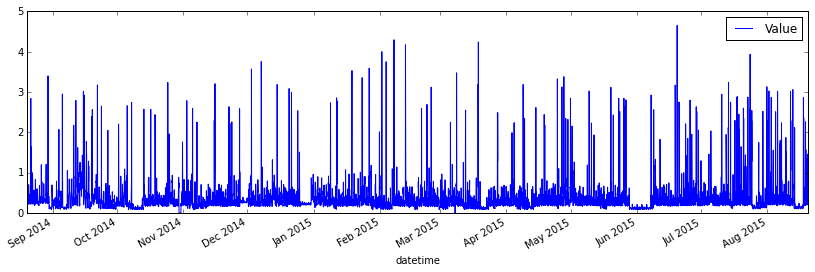

In [7]:

eUse.use_df.plot(x="datetime", y="Value", figsize=(14,4))

In [8]:
eUse.get_cost()

687.52601700000002

In [15]:

solar_data = pd.read_csv("Solar-calculator--pvwatts_hourly.csv",thousands=',')

In [16]:
solar_data["datetime"] = solar_data.apply( lambda row:  datetime.datetime( year=2016, month=int(row["Month"]), day=int(row["Day"])
                                                 , hour=int(row["Hour"]) ), axis=1 )

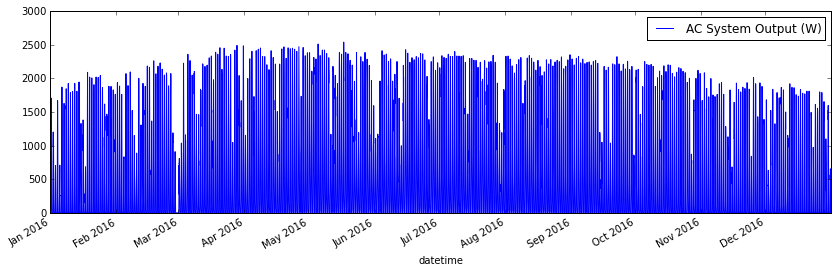

In [18]:
solar_data.plot( x="datetime", y="AC System Output (W)",figsize=(14,4))

## Estimated use with EV
### hourly estimate for charging
### hourly estimate for solar credits

In [24]:
#ev_costs_per_month = electr_cost_per_month( miles_per_month, erates.get_ave_rate(), volt.kwh_per_mile )
charge_rate_kw = 3.3
energy_per_day_kwh = volt.kwh_per_mile * miles_per_month * 12.0/360.0
hours_per_charge = energy_per_day_kwh/charge_rate_kw

#Assume charging starts at 00:00
# make a pandas DF object to hold times and energy use
# get cost per hour
charge_hour = 0
hours_left = hours_per_charge
while( hours_left > 0 ):
    if hours_left > 1:
        hours_left =- 1;
        


<electric_rates.elect_use_cost_tou instance at 0x000000000BBA35C8>

## do a per-hour difference of cost vs. generation